# Federated Learning

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import sys
sys.path.insert(0, '..')

In [4]:
from data.frecency import sample, frecency_points
from data.frecency import sample_suggestions_normal as sample_suggestions

## Linear Regression

This section is mostly to check that's it possible to fit a linear model perfectly to the data.

In [5]:
from sklearn.linear_model import LinearRegression

To fit a model, we sample a lot of these scores and also add noise on top to make the problem more similar to the real application.

In [6]:
n = int(1e6)
noise = np.random.normal(0, 2, size=(n))
X, y = sample(n)
y += noise

In [7]:
model = LinearRegression(fit_intercept=False)
model.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None,
         normalize=False)

The resulting coefficients are extremely close to the actual frecency weights. How close they are depends on how much noise we add to the data matrix.

In [8]:
zip(model.coef_, frecency_points)

[(120.00159750999515, 120.0),
 (35.994674183889856, 36.0),
 (97.99060385491362, 98.0),
 (14.011544426351845, 14.0),
 (20.00909549464527, 20.0),
 (100.00919657578298, 100.0),
 (140.00754060124282, 140.0),
 (69.99600472596933, 70.0),
 (199.98257062705986, 200.0),
 (41.993561491778806, 42.0),
 (60.0031611350459, 60.0),
 (139.99371551616719, 140.0),
 (11.996226935356527, 12.0),
 (60.00358900094553, 60.0),
 (83.9972314373345, 84.0)]

In [9]:
model.coef_ - frecency_points

array([ 0.00159751, -0.00532582, -0.00939615,  0.01154443,  0.00909549,
        0.00919658,  0.0075406 , -0.00399527, -0.01742937, -0.00643851,
        0.00316114, -0.00628448, -0.00377306,  0.003589  , -0.00276856])

## Ranking and SVM loss

Now, we make the problem slightly more difficult: Instead of just learning the frecency function from data, we try to learn it from user interactions. The training data now consists of a variable number of history suggestions and their respective features. The label corresponds to the suggestion that the user clicked on. We still assume that the user clicks on the item with the highest frecency score.

### Preprocessing

Gradient descent generally works better when the data is centered around the origin:

In [10]:
from utils import normalize

In [11]:
X = normalize(X)

### Optimizers

In [12]:
from optimizers import GradientDescent, AdaptiveGradientDescent, DecayedGradientDescent, RProp, Adam

### Hinge Loss (SVM loss)

To supervise training, we keep logging the loss:

In [13]:
def svm_loss(preds, ys, delta=0):
    correct = ys.argmax()
    score_correct = preds[correct]
    
    loss = 0
    
    for i, pred in enumerate(preds):
        loss += max(0, pred + delta - score_correct)            
            
    return loss

### Helpers

During training, we want to supervise the learning process and save the best models.

In [14]:
from utils import ModelCheckpoint

accuracy needs to be measured carefully here: In our simulation, we assume that the current frecency is the perfect ranking function. But because items sometimes get the same frecency scores, there can be more than one correct answer:

In [15]:
def rank_accuracy(y, preds):
    correct = 0.
    
    for yi, pi in zip(y, preds):
        if yi[pi.argmax()] == yi.max():
            correct += 1
            
    return correct / len(y)

The `SVMRanking` class is the main mechanism for fitting models.

In [16]:
class SVMRanking:
    def __init__(self, delta):
        self.delta = delta
        
    def fit(self, data_generator, optimizer, num_iterations=10, callbacks=[]):
        X, y = data_generator(2)
        num_features = X[0].shape[1]
        self.W = frecency_points + (np.random.random(size=(num_features)) - 0.5) * 100
        
        for j in range(num_iterations):
            X, y = data_generator(4000)
            
            preds = self.predict(X)
            gradient = np.zeros(num_features)

            for xi, pi, yi in zip(X, preds, y):
                correct = yi.argmax()
                score_correct = pi[correct]

                for i, predicted_score in enumerate(pi):
                    gradient -= xi[i] * max(0, predicted_score + self.delta - score_correct)
            
            gradient /= len(X)
            
            loss = np.mean([svm_loss(pi, yi) for pi, yi in zip(self.predict(X), y)])
            accuracy = rank_accuracy(y, model.predict(X))
            
            print("[%d/%d] training: %.5f loss, %.3f accuracy" % (j + 1, num_iterations, loss, accuracy))
            
            for callback in callbacks:
                callback(self)
            
            self.W += optimizer(gradient)
            
    def predict(self, X):
        preds = []
        
        for x in X:
            scores = x.dot(self.W)
            preds.append(scores)
        
        return preds

### Training

In [17]:
np.random.seed(0)
model = SVMRanking(delta=0.)
model.fit(data_generator=sample_suggestions,
          optimizer=GradientDescent(30.),
          num_iterations=48,
          callbacks=[ModelCheckpoint(rank_accuracy, sample_suggestions)])

[1/48] training: 3.80225 loss, 0.787 accuracy
[ModelCheckpoint] New best model with 0.79670 validation accuracy
[2/48] training: 1.60038 loss, 0.944 accuracy
[ModelCheckpoint] New best model with 0.94620 validation accuracy
[3/48] training: 0.77972 loss, 0.963 accuracy
[ModelCheckpoint] New best model with 0.96370 validation accuracy
[4/48] training: 0.63540 loss, 0.964 accuracy
[ModelCheckpoint] New best model with 0.96460 validation accuracy
[5/48] training: 0.35693 loss, 0.968 accuracy
validation: 0.963 accuracy
[6/48] training: 0.56707 loss, 0.967 accuracy
validation: 0.963 accuracy
[7/48] training: 0.39944 loss, 0.965 accuracy
[ModelCheckpoint] New best model with 0.96570 validation accuracy
[8/48] training: 0.33584 loss, 0.961 accuracy
[ModelCheckpoint] New best model with 0.96870 validation accuracy
[9/48] training: 0.40017 loss, 0.963 accuracy
validation: 0.965 accuracy
[10/48] training: 0.25135 loss, 0.967 accuracy
validation: 0.966 accuracy
[11/48] training: 0.14411 loss, 0.9

In [18]:
np.random.seed(0)
opt = AdaptiveGradientDescent(0.1, len(frecency_points))
model = SVMRanking(delta=0.)
model.fit(data_generator=sample_suggestions,
          optimizer=opt,
          num_iterations=48,
          callbacks=[ModelCheckpoint(rank_accuracy,  sample_suggestions)])

[1/48] training: 3.80225 loss, 0.787 accuracy
[ModelCheckpoint] New best model with 0.79670 validation accuracy
[2/48] training: 4.16381 loss, 0.802 accuracy
[ModelCheckpoint] New best model with 0.80270 validation accuracy
[3/48] training: 4.18797 loss, 0.793 accuracy
[ModelCheckpoint] New best model with 0.80420 validation accuracy
[4/48] training: 3.97512 loss, 0.803 accuracy
validation: 0.803 accuracy
[5/48] training: 3.50770 loss, 0.802 accuracy
validation: 0.794 accuracy
[6/48] training: 4.08533 loss, 0.794 accuracy
validation: 0.803 accuracy
[7/48] training: 3.82384 loss, 0.796 accuracy
validation: 0.801 accuracy
[8/48] training: 3.76828 loss, 0.796 accuracy
validation: 0.804 accuracy
[9/48] training: 3.70492 loss, 0.804 accuracy
validation: 0.796 accuracy
[10/48] training: 3.74066 loss, 0.795 accuracy
validation: 0.793 accuracy
[11/48] training: 3.10902 loss, 0.804 accuracy
validation: 0.802 accuracy
[12/48] training: 3.05052 loss, 0.796 accuracy
validation: 0.799 accuracy
[13/

After fitting, we can compare the learned weights with the true frecency scores. Note that the values themselves are very different now but that the ordering is nearly the same as in the real algorithm. This shows that we are ranking very similarly to the real algorithm but that the optimization process did not fully reach the global optimum.

In [19]:
ais = np.argsort(frecency_points)
zip(frecency_points[ais], model.W[ais])

[(12.0, -25.894926149162654),
 (14.0, -11.4372848210452),
 (20.0, -28.121019956364485),
 (36.0, 16.02788591203444),
 (42.0, 17.034268043118946),
 (60.0, 16.89757031759994),
 (60.0, 16.022547162926983),
 (70.0, 81.69339968747569),
 (84.0, 93.61502353018228),
 (98.0, 93.61503322165485),
 (100.0, 96.45505594743021),
 (120.0, 96.45556121046269),
 (140.0, 133.7030249046363),
 (140.0, 133.70317284652117),
 (200.0, 244.3748078514624)]

Still, the model is correct most of the time:

In [20]:
X, y = sample_suggestions(10000)
rank_accuracy(y, model.predict(X))

0.9872

### Side note: Evaluation during training in production

If we only use 400 data points for validating the current model, then this is not enough to properly assess the model quality.
The accuracies jump too much.
However, this evaluation could still be used to test that the model is not completely off.

(array([  2.,   6.,   8.,  59.,  85., 119., 382., 184., 100.,  54.]),
 array([0.9675 , 0.97075, 0.974  , 0.97725, 0.9805 , 0.98375, 0.987  ,
        0.99025, 0.9935 , 0.99675, 1.     ]),
 <a list of 10 Patch objects>)

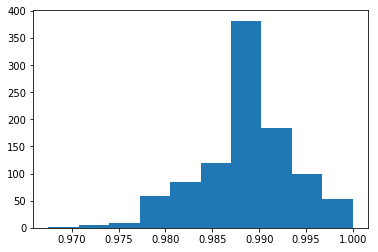

In [21]:
X, y = sample_suggestions(1000 * 400)
accuracies = []

for i in range(0, len(X) - 400, 400):
    Xi, yi = X[i:i+400], y[i:i+400]
    acc = rank_accuracy(yi, model.predict(Xi))
    accuracies.append(acc)
    
plt.hist(sorted(accuracies))

## Frequency

We still need to take into account that users visit links more than once.
How often a user visits a link is sampled from an exponential distribution in this simulation:

(array([559., 226., 131.,  44.,  22.,   5.,   7.,   4.,   1.,   1.]),
 array([ 0. ,  5.5, 11. , 16.5, 22. , 27.5, 33. , 38.5, 44. , 49.5, 55. ]),
 <a list of 10 Patch objects>)

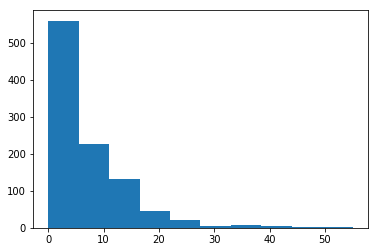

In [22]:
frequencies = np.int32(np.random.exponential(7, size=(1000)))
plt.hist(frequencies)

In [23]:
def sample_url_features(num_samples):
    frequencies = np.int32(np.random.exponential(7, size=num_samples)) + 1
    frequencies = np.int32(np.ones(num_samples))
    X = []
    
    for frequency in frequencies:
        num_sampled = min(10, frequency)
        features = sample_weighted(num_sampled, weights).sum(axis=0)
        X.append(frequency / num_sampled * features)
        
    return np.array(X)

In [24]:
model = SVMRanking(delta=0.)
model.fit(data_generator=sample_suggestions,
          optimizer=GradientDescent(30.),
          num_iterations=48,
          callbacks=[ModelCheckpoint(rank_accuracy, sample_suggestions, 10000)])

[1/48] training: 6.53765 loss, 0.893 accuracy
[ModelCheckpoint] New best model with 0.89780 validation accuracy
[2/48] training: 2.03379 loss, 0.931 accuracy
[ModelCheckpoint] New best model with 0.92590 validation accuracy
[3/48] training: 0.89471 loss, 0.956 accuracy
[ModelCheckpoint] New best model with 0.95630 validation accuracy
[4/48] training: 0.51674 loss, 0.964 accuracy
[ModelCheckpoint] New best model with 0.96420 validation accuracy
[5/48] training: 0.45467 loss, 0.966 accuracy
[ModelCheckpoint] New best model with 0.96470 validation accuracy
[6/48] training: 0.39497 loss, 0.962 accuracy
validation: 0.963 accuracy
[7/48] training: 0.18825 loss, 0.965 accuracy
[ModelCheckpoint] New best model with 0.96640 validation accuracy
[8/48] training: 0.17068 loss, 0.968 accuracy
validation: 0.960 accuracy
[9/48] training: 0.11503 loss, 0.963 accuracy
validation: 0.965 accuracy
[10/48] training: 0.13593 loss, 0.959 accuracy
validation: 0.963 accuracy
[11/48] training: 0.15025 loss, 0.9

## Federated Learning

To implement a federated version of the model above, we have to create a `Client` class that completely encapsulates training data. Only the `Client` can compute gradients based on its own data. While the `Server` is the main class for controlling the training process, it can only request gradients from clients.

In [25]:
import random

In [26]:
class Server:
    def __init__(self, clients):
        self.clients = clients
        
        num_features = len(frecency_points)
        self.W = np.int32(frecency_points + (np.random.random(size=(num_features)) - 0.5) * 100)
    
    def fit(self, optimizer, num_iterations, num_clients_per_iteration, constraints=[], callbacks=[]):
        for j in range(num_iterations):
            clients = random.sample(self.clients, num_clients_per_iteration)
            updates, losses = zip(*[client.request_update(self) for client in clients])
            
            gradient = np.mean(updates, axis=0)
            loss = np.mean(losses, axis=0)
            
            print("[%d/%d] training loss across clients %.5f" % (j + 1, num_iterations, loss))
            
            for callback in callbacks:
                callback(self)
            
            self.W += np.int32(optimizer(gradient))
            
            for constraint in constraints:
                self.W = constraint(self.W)
            
    def predict(self, X):
        preds = []
        
        for x in X:
            scores = x.dot(self.W)
            preds.append(scores)
        
        return preds

In [27]:
class AnalyticalClient:
    def __init__(self, data_generator, delta=0):
        self.data_generator = data_generator
        self.delta = 0
    
    def request_update(self, model):
        X, y = self.data_generator()
        preds = model.predict(X)
        
        num_features = X[0].shape[1]
        gradient = np.zeros(num_features)
        loss = 0

        for xi, pi, yi in zip(X, preds, y):
            correct = yi.argmax()
            score_correct = pi[correct]

            for i, predicted_score in enumerate(pi):
                gradient -= xi[i] * max(0, predicted_score + self.delta - score_correct)
            
            loss += svm_loss(pi, yi)
                
        gradient /= len(X)
        loss /= len(X)
        
        return gradient, loss

In [28]:
class FrecencyConstraints:
    def __call__(self, gradient):
        return gradient - min(0, gradient.min())

How many data points a user has in each round is sampled from the following exponential distribution:

(array([723.,   0., 200.,   0.,  60.,   0.,  13.,   0.,   2.,   2.]),
 array([2. , 2.5, 3. , 3.5, 4. , 4.5, 5. , 5.5, 6. , 6.5, 7. ]),
 <a list of 10 Patch objects>)

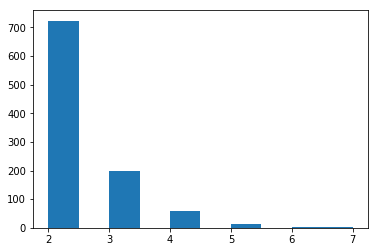

In [29]:
num_datapoints = np.int32(np.random.exponential(.8, size=(1000))) + 2
plt.hist(num_datapoints)

We have 5000 clients:

In [30]:
clients = [AnalyticalClient(lambda: sample_suggestions(np.int32(np.random.exponential(.8)) + 2)) for _ in range(5000)]

In [31]:
np.random.seed(10)
server = Server(clients)
server.fit(optimizer=GradientDescent(30.),
          num_iterations=48,
           num_clients_per_iteration=400,
           constraints=[FrecencyConstraints()],
          callbacks=[ModelCheckpoint(rank_accuracy, sample_suggestions, 5000)])

[1/48] training loss across clients 12.50804
[ModelCheckpoint] New best model with 0.75240 validation accuracy
[2/48] training loss across clients 54.66287
validation: 0.591 accuracy
[3/48] training loss across clients 89.68266
[ModelCheckpoint] New best model with 0.82900 validation accuracy
[4/48] training loss across clients 6.24904
[ModelCheckpoint] New best model with 0.97820 validation accuracy
[5/48] training loss across clients 5.24104
validation: 0.975 accuracy
[6/48] training loss across clients 2.98337
[ModelCheckpoint] New best model with 0.97940 validation accuracy
[7/48] training loss across clients 1.87258
validation: 0.979 accuracy
[8/48] training loss across clients 1.57953
[ModelCheckpoint] New best model with 0.98100 validation accuracy
[9/48] training loss across clients 4.44021
validation: 0.979 accuracy
[10/48] training loss across clients 3.73792
validation: 0.979 accuracy
[11/48] training loss across clients 1.19375
[ModelCheckpoint] New best model with 0.98160 

=> The model quality improved from 70% to >97% validation accuracy.

In [32]:
zip(frecency_points[ais], server.W[ais])

[(12.0, 0),
 (14.0, 151),
 (20.0, 149),
 (36.0, 144),
 (42.0, 564),
 (60.0, 561),
 (60.0, 567),
 (70.0, 775),
 (84.0, 826),
 (98.0, 856),
 (100.0, 855),
 (120.0, 967),
 (140.0, 1018),
 (140.0, 1018),
 (200.0, 1123)]

### With RProp

[RProp](https://florian.github.io/rprop/) is a gradient descent variation that ignores the magnitude of the gradient.
The general motivation for this is that the mangitude can be misleading since it does not have to contain useful information for the step size.

The motivation for using RProp in our case is a little bit different: Since we do not collect any training data at all, we have no idea how large the gradient mangitudes are going to be. This is problematic because it makes it very hard to properly configure the learning rate beforehand.
To deal with this, we can use RProp to only take into account the signs of gradients.

This also makes updates much easier to interpret: They change each frecency weight between 1 and 3, depending on how strong the feedback signal for that weight has been in the past.

In [33]:
np.random.seed(10)
opt = opt = RProp(2., len(frecency_points), min_value=1, max_value=3, alpha=2., beta=0.6)
server = Server(clients)
server.fit(optimizer=opt,
          num_iterations=48,
           num_clients_per_iteration=400,
           constraints=[FrecencyConstraints()],
          callbacks=[ModelCheckpoint(rank_accuracy, sample_suggestions, 5000)])

[1/48] training loss across clients 12.50804
[ModelCheckpoint] New best model with 0.75240 validation accuracy
[2/48] training loss across clients 13.21671
[ModelCheckpoint] New best model with 0.75560 validation accuracy
[3/48] training loss across clients 10.19690
[ModelCheckpoint] New best model with 0.75900 validation accuracy
[4/48] training loss across clients 8.77127
[ModelCheckpoint] New best model with 0.79860 validation accuracy
[5/48] training loss across clients 8.40608
validation: 0.797 accuracy
[6/48] training loss across clients 6.13325
[ModelCheckpoint] New best model with 0.80240 validation accuracy
[7/48] training loss across clients 5.91335
validation: 0.799 accuracy
[8/48] training loss across clients 5.21768
[ModelCheckpoint] New best model with 0.86460 validation accuracy
[9/48] training loss across clients 4.51546
[ModelCheckpoint] New best model with 0.87060 validation accuracy
[10/48] training loss across clients 4.57298
validation: 0.869 accuracy
[11/48] train

In [34]:
opt.learning_rates

array([3., 2., 3., 3., 3., 2., 2., 3., 2., 2., 3., 3., 2., 2., 3.])

In [35]:
zip(frecency_points[ais], server.W[ais])

[(12.0, 0),
 (14.0, 22),
 (20.0, 24),
 (36.0, 26),
 (42.0, 37),
 (60.0, 98),
 (60.0, 98),
 (70.0, 104),
 (84.0, 105),
 (98.0, 107),
 (100.0, 109),
 (120.0, 140),
 (140.0, 142),
 (140.0, 142),
 (200.0, 203)]

Even in the simulation this works a bit better. It's the only optimizer that reaches a perfect score. In a real life application, it is also much more practical, as explained above.

### With numerical gradient computation

So far all simulations were based on the fact that we knew how to analytically derive the gradient.
This is not the case for the actual addon, which uses a simple [finite difference method](https://en.wikipedia.org/wiki/Finite_difference_method) of computing the gradient.
To make sure the simulations still work, the following reconstructs the important part of the client-side code.

In [36]:
def full_loss(model, loss_fn, X, y):
    preds = model.predict(X)
    return sum([loss_fn(pi, yi) for pi, yi in zip(preds, y)]) / len(X)

In [37]:
class NumericalClient:
    def __init__(self, data_generator, delta=0):
        self.data_generator = data_generator
        self.delta = 0
    
    def request_update(self, model, eps=1):
        X, y = self.data_generator()
        loss = full_loss(model, svm_loss, X, y)
        
        num_features = X[0].shape[1]
        gradient = []
        
        for i in range(num_features):
            model.W[i] -= eps
            loss1 = full_loss(model, svm_loss, X, y)
            
            model.W[i] += 2 * eps
            loss2 = full_loss(model, svm_loss, X, y)
            
            finite_difference = (loss1 - loss2) / (2 * eps)
            gradient.append(finite_difference)
            
            model.W[i] -= eps
        
        return gradient, loss

In [38]:
clients = [NumericalClient(lambda: sample_suggestions(np.int32(np.random.exponential(.8)) + 2)) for _ in range(5000)]

In [39]:
np.random.seed(10)
opt = opt = RProp(2., len(frecency_points), min_value=1, max_value=3, alpha=2., beta=0.6)
server = Server(clients)
server.fit(optimizer=opt,
          num_iterations=48,
           num_clients_per_iteration=400,
           constraints=[FrecencyConstraints()],
          callbacks=[ModelCheckpoint(rank_accuracy, sample_suggestions, 5000)])

[1/48] training loss across clients 12.50804
[ModelCheckpoint] New best model with 0.75240 validation accuracy
[2/48] training loss across clients 12.14904
[ModelCheckpoint] New best model with 0.75880 validation accuracy
[3/48] training loss across clients 8.42656
[ModelCheckpoint] New best model with 0.80900 validation accuracy
[4/48] training loss across clients 6.27468
[ModelCheckpoint] New best model with 0.81660 validation accuracy
[5/48] training loss across clients 4.96587
[ModelCheckpoint] New best model with 0.88140 validation accuracy
[6/48] training loss across clients 2.97904
[ModelCheckpoint] New best model with 0.88820 validation accuracy
[7/48] training loss across clients 1.94895
[ModelCheckpoint] New best model with 0.88920 validation accuracy
[8/48] training loss across clients 0.97425
[ModelCheckpoint] New best model with 0.96900 validation accuracy
[9/48] training loss across clients 0.75292
[ModelCheckpoint] New best model with 0.99020 validation accuracy
[10/48] 

In [40]:
opt.learning_rates

array([3., 3., 2., 3., 3., 3., 1., 3., 3., 3., 1., 1., 2., 1., 3.])

In [41]:
zip(frecency_points[ais], server.W[ais])

[(12.0, 0),
 (14.0, 46),
 (20.0, 48),
 (36.0, 52),
 (42.0, 54),
 (60.0, 107),
 (60.0, 106),
 (70.0, 119),
 (84.0, 126),
 (98.0, 131),
 (100.0, 135),
 (120.0, 164),
 (140.0, 183),
 (140.0, 185),
 (200.0, 214)]

The model still converges nicely with this method.

# Notes 

Simplifications made:

- All users sample from the same distribution
- `ModelCheckpoint` cannot be based on validation data in the actual implementation
- Users should run more than one SGD iteration locally

## To make fitting easier

- Fair initialization
- Normalize data (0-center)
- Remove features with a value of 0

## Still missing

- Implement frequency part (switch from one-hot encoding to up to sum of 10 and add multiplicative factor)